In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.base import clone 
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, balanced_accuracy_score, \
    precision_score, recall_score, f1_score, roc_curve, precision_recall_curve

# Import Data

In [2]:
teams = pd.read_csv('data/MDataFiles_Stage1/MTeams.csv')
teams.info()
teams[teams['TeamName'].isin(['Virginia', 'Texas Tech'])]  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
TeamID           367 non-null int64
TeamName         367 non-null object
FirstD1Season    367 non-null int64
LastD1Season     367 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.5+ KB


,TeamID,TeamName,FirstD1Season,LastD1Season
302,1403,Texas Tech,1985,2020
337,1438,Virginia,1985,2020


In [3]:
seeds = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneySeeds.csv')
seeds.info()
seeds.query("TeamID == 1438").tail(3) # UVA seedings last 3 years

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286 entries, 0 to 2285
Data columns (total 3 columns):
Season    2286 non-null int64
Seed      2286 non-null object
TeamID    2286 non-null int64
dtypes: int64(2), object(1)
memory usage: 53.7+ KB


,Season,Seed,TeamID
2086,2017,W05,1438
2185,2018,Y01,1438
2270,2019,Z01,1438


In [4]:
tourney_results = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_results.info()
tourney_results.query("WTeamID == 1438 | LTeamID == 1438").tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 8 columns):
Season     2251 non-null int64
DayNum     2251 non-null int64
WTeamID    2251 non-null int64
WScore     2251 non-null int64
LTeamID    2251 non-null int64
LScore     2251 non-null int64
WLoc       2251 non-null object
NumOT      2251 non-null int64
dtypes: int64(7), object(1)
memory usage: 140.8+ KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2245,2019,145,1438,80,1345,75,N,1
2249,2019,152,1438,63,1120,62,N,0
2250,2019,154,1438,85,1403,77,N,1


In [5]:
regular_results = pd.read_csv('data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv') 
regular_results.info()
regular_results.query("WTeamID == 1438 | LTeamID == 1438").tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161552 entries, 0 to 161551
Data columns (total 8 columns):
Season     161552 non-null int64
DayNum     161552 non-null int64
WTeamID    161552 non-null int64
WScore     161552 non-null int64
LTeamID    161552 non-null int64
LScore     161552 non-null int64
WLoc       161552 non-null object
NumOT      161552 non-null int64
dtypes: int64(7), object(1)
memory usage: 9.9+ MB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
161319,2019,124,1438,73,1257,68,H,0
161469,2019,129,1438,76,1301,56,N,0
161486,2019,130,1199,69,1438,59,N,0


In [6]:
public_rankings = pd.read_csv('data/MDataFiles_Stage1/MMasseyOrdinals.csv') 
public_rankings.info()
public_rankings.query("TeamID == 1438").tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3820919 entries, 0 to 3820918
Data columns (total 5 columns):
Season           int64
RankingDayNum    int64
SystemName       object
TeamID           int64
OrdinalRank      int64
dtypes: int64(4), object(1)
memory usage: 145.8+ MB


,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3820186,2019,133,WOL,1438,1
3820539,2019,133,YAG,1438,3
3820892,2019,133,ZAM,1438,2


# Helper Functions

In [7]:
def clf_eda_numeric(data, feature, target='Won'):
    """ Creates EDA plots for a binary target vs. a select numeric feature """
    
    # set up axes and define attributes 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
    neutral_color = list(plt.rcParams['axes.prop_cycle'])[3]['color']
    
    # top-left: boxplot 
    sns.boxplot(x=target, y=feature, data=data, ax=axes[0,0]) 
    
    # top-right: overlapping density plots, 1 for each class  
    for y in [0,1]:
        subset = data[data[target]==y]
        sns.distplot(subset[feature], label=y, ax=axes[0,1])
        xmin, xmax = data[feature].min(), data[feature].max()
        axes[0,1].set_xlim(xmin, xmax)
        axes[0,1].set_ylabel('Density')
        axes[0,1].legend()
        
    # bottom-left: line plot of average target by feature value  
    sns.lineplot(x=feature, y=target, color=neutral_color, data=data, ax=axes[1,0])
    
    # bottom-right: histogram of combined data 
    sns.distplot(data[feature], kde=False, norm_hist=True, label='Density', color=neutral_color, ax=axes[1,1])

# Construct Dataset + Engineer Features

### Create IDs and Labels

Each observation in our dataset is a March Madness match-up between two teams in a particular season, uniquely identified by a SSSS_XXXX_YYYY ID, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team. The label of this observation is the outcome of the game, indicating whether the lower-ID team wins (1) or loses (0). 

In [8]:
def create_match_ups(seeds, seasons=None): 
    """ Given seeds dataframe and a tuple of (start, end) seasons, generate all possible match ups for each season """
    
    seeds = seeds.copy() 
    
    # filter for relevant seasons 
    if seasons is not None: 
        start_season, end_season = seasons 
        seeds = seeds[(seeds["Season"] >= start_season) & (seeds["Season"] <= end_season)]
        
    # generate pairwise match-ups 
    pairs = seeds\
        .merge(seeds, how='left', on=['Season'], suffixes=['_A', '_B'])\
        .drop(['Seed_A', 'Seed_B'], axis=1)\
        .query("TeamID_A < TeamID_B")\
        .rename(columns={'TeamID_A': 'TeamA', 'TeamID_B': 'TeamB'})\
        .assign(Teams = lambda x: x['TeamA'].astype(str) + '_' + x['TeamB'].astype(str))\
        .assign(ID = lambda x: x['Season'].astype(str) + '_' + x['Teams'])
        
    return pairs

def reformat_results(results):
    """ Reformat results into a more useful format (WTeamID/LTeamID --> TeamA/TeamB) """
    
    reformatted = results.assign(
        TeamA = lambda x: x[['WTeamID','LTeamID']].min(axis=1), 
        TeamB = lambda x: x[['WTeamID','LTeamID']].max(axis=1), 
        Teams = lambda x: x['TeamA'].astype(str) + '_' + x['TeamB'].astype(str),
        ID = lambda x: x['Season'].astype(str) + '_' + x['Teams'],
        Won = lambda x: np.where(x['WTeamID'] < x['LTeamID'], 1, 0),
        ScoreTeamA = lambda x: np.where(x['WTeamID'] == x['TeamA'], x['WScore'], x['LScore']),
        ScoreTeamB = lambda x: np.where(x['WTeamID'] == x['TeamB'], x['WScore'], x['LScore']),
        ScoreDiff = lambda x: x['ScoreTeamA'] - x['ScoreTeamB']
    )
    
    cols_to_return = ['ID', 'Season', 'TeamA', 'TeamB', 'Teams', 'Won', 
                      'ScoreTeamA', 'ScoreTeamB', 'ScoreDiff', 'DayNum', 'NumOT', 'WLoc']
    
    return reformatted[cols_to_return] 

def append_labels(pairs, tourney_results):
    """ Given set of all possible match-ups, reduce to pairs with historical results, and append relevant labels """
    tourney_results_reformatted = reformat_results(tourney_results)
    labeled = pairs.merge(tourney_results_reformatted[['ID', 'Won']], how='inner', on='ID')
    return labeled

In [9]:
pairs = create_match_ups(seeds, seasons=(1985, 2019))
labeled_pairs = append_labels(pairs, tourney_results)
print("There are {} possible match-ups, but only {} were realized and have labels to train with!".format(
    len(pairs), len(labeled_pairs)))

There are 73558 possible match-ups, but only 2251 were realized and have labels to train with!


In [10]:
labeled_pairs.info()
labeled_pairs.query("Teams == '1403_1438'") # UVA beat Texas Tech in the championship final last year 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2251 entries, 0 to 2250
Data columns (total 6 columns):
Season    2251 non-null int64
TeamA     2251 non-null int64
TeamB     2251 non-null int64
Teams     2251 non-null object
ID        2251 non-null object
Won       2251 non-null int64
dtypes: int64(4), object(2)
memory usage: 123.1+ KB


,Season,TeamA,TeamB,Teams,ID,Won
2205,2019,1403,1438,1403_1438,2019_1403_1438,0


### Engineer Feature #1: Seed Difference

Generally we expect the higher-seeded team to win, and the greater the gap in seedings, the more confident we are. Here we create the feature `SeedDiff` to represent how much higher the lower-ID team is seeded above the higher-ID team. For example, `SeedDiff`=-2 for `ID`=2019_1403_1438 means that #3 Texas Tech (ID:1403) was seeded two positions below #1 Virginia (ID:1438) in 2019. Our EDA reveals past outcomes are consistent with our beliefs. 

In [11]:
def append_seed_features(data, seeds):
    """ Create seed features and append to main dataframe """
    seeds = seeds.copy() 
    seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
    seeds = seeds.set_index(['Season', 'TeamID'])
    df = data.merge(seeds, how='left', left_on=['Season', 'TeamA'], right_index=True)\
             .merge(seeds, how='left', left_on=['Season', 'TeamB'], right_index=True, suffixes=('A', 'B'))
    df['SeedDiff'] = df['SeedB'] - df['SeedA'] 
    return df 

In [12]:
seeds_df = append_seed_features(labeled_pairs, seeds)
display(seeds_df.query("Teams == '1403_1438'"))

,Season,TeamA,TeamB,Teams,ID,Won,SeedA,SeedB,SeedDiff
2205,2019,1403,1438,1403_1438,2019_1403_1438,0,3,1,-2


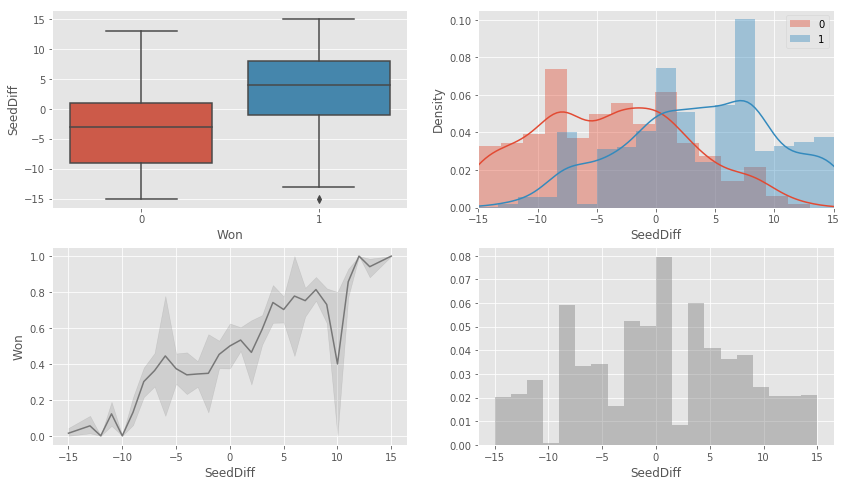

In [13]:
clf_eda_numeric(seeds_df, feature='SeedDiff')

### Engineer Feature #2: Ranking Difference

While seeds are a good indicator of the teams' relative standings, one limitation is that teams are divided into four regions, and seeds are assigned within each region. This means there are 4 #1-seed teams, 4 #2-seed teams, etc. and thus the seeds are not necessarily comparable across regions. For example, we do not know which of two #1-ranked seeds compare in case they meet in the Championship finals, nor do we know #3 seed from one conference is necessarily weaker than #2 seed from another. 

This might not matter that much for the purpose of this competition, since all games are equally weighted, and vast majority of the realized match-ups occur between teams in the same region, with the exception of Final Four and Championship games. That said, I think rankings also provide us with more granular information about the relative strengths of seeds within the same region, so we will include them as one of our features.  

Note that we are provided with ranking history from 174 distinct sources, of which we would only use the 14 that include all 300+ D1 teams, and have data dating back to 2003. We compute `RankDiff` to represent how many positions the lower-ID team is ranked higher than the higher-ID team prior to the first March Madness game, aggregating across various ranking sources by taking the maximum (performed better than other aggregation methods empirically).

In [14]:
# use only ranking systems that have data between 2003 and 2019, and ranks all teams 
rank_systems = public_rankings.groupby('SystemName')['Season','OrdinalRank'].agg(['min','max']).reset_index()
rank_systems.columns = rank_systems.columns.get_level_values(0) + rank_systems.columns.get_level_values(1)
RANK_SYSTEMS_TO_USE = rank_systems[
    (rank_systems['Seasonmin']<=2003) & (rank_systems['Seasonmax']==2019) &
    (rank_systems['OrdinalRankmax'] > 300)]['SystemName'].tolist()
print(RANK_SYSTEMS_TO_USE)

['ARG', 'BIH', 'COL', 'DOL', 'DUN', 'MAS', 'MOR', 'POM', 'RTH', 'SAG', 'SEL', 'WLK', 'WOB', 'WOL']


In [15]:
def append_ranking_features(data, public_rankings, systems_to_use=RANK_SYSTEMS_TO_USE):
    """ Append rank differences (positive diff means lower-id team is ranked higher) as features, 
        one per ranking system """
    ranks = public_rankings[(public_rankings['SystemName'].isin(systems_to_use)) & 
                            (public_rankings['RankingDayNum'] == 133)].drop('RankingDayNum', axis=1)
    ranks = ranks.pivot_table(index=['Season', 'TeamID'], columns='SystemName', values='OrdinalRank')
    output = data.merge(ranks, how='left', left_on=['Season','TeamA'], right_index=True)\
                 .merge(ranks, how='left', left_on=['Season','TeamB'], right_index=True, suffixes=('_A','_B'))
    for sys in systems_to_use:
        output['RankDiff' + sys] = output[sys + '_B'] - output[sys + '_A']
        output.drop([sys+'_A', sys+'_B'], axis=1, inplace=True)
        
    output['RankDiffAVG'] = output[[col for col in output.columns if 'RankDiff' in col]].mean(axis=1)
    output['RankDiffMIN'] = output[[col for col in output.columns if 'RankDiff' in col]].min(axis=1)
    output['RankDiffMAX'] = output[[col for col in output.columns if 'RankDiff' in col]].max(axis=1)
    output['RankDiffMEDIAN'] = output[[col for col in output.columns if 'RankDiff' in col]].median(axis=1)

    return output

In [16]:
rankings_df = append_ranking_features(labeled_pairs, public_rankings)
rankings_df.query("Teams == '1403_1438'")

/Users/garyng/anaconda3/envs/py37base/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,Season,TeamA,TeamB,Teams,ID,Won,RankDiffARG,RankDiffBIH,RankDiffCOL,RankDiffDOL,...,RankDiffRTH,RankDiffSAG,RankDiffSEL,RankDiffWLK,RankDiffWOB,RankDiffWOL,RankDiffAVG,RankDiffMIN,RankDiffMAX,RankDiffMEDIAN
2205,2019,1403,1438,1403_1438,2019_1403_1438,0,-9.0,-9.0,-11.0,-10.0,...,-9.0,-7.0,-9.0,-8.0,-9.0,-13.0,-9.357143,-15.0,-6.0,-9.0


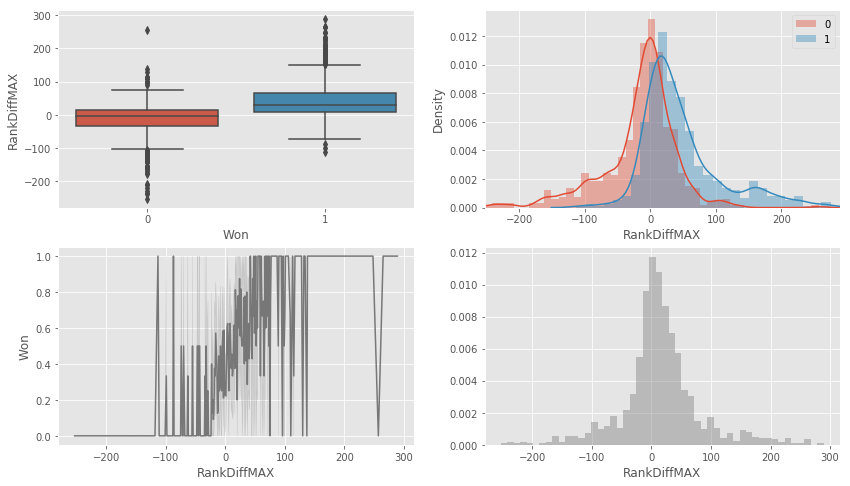

In [17]:
clf_eda_numeric(rankings_df.query("Season >= 2003"), feature='RankDiffMAX')

### Engineer Feature #3: Pedigree Difference

Seeds and rankings capture only the teams' relative standings in the current season. However, teams with a storied history like UNC, Duke, and Villanova can never be counted out even if they had a poor regular season that resulted in them being seeded or ranked lower. Perhaps due to the big game experience that these coaches/players have, or an intangible "belief" that they can do it, teams that have historically advanced farther in the tournament might have an edge over historically less-successful teams. 

To quantify this difference, I assigned each team a numeric `Pedigree` score (1 to 16) in each season, based on the farthest the team had advanced to in years prior to the current season: 1 for Sweet Sixteen, 2 for Elite Eight, 3 for Final 4, 4 for making it to Championship Final, and 5 for winning it all. To facilitate pairwise comparison, we compute `PedigreeDiff` to represent the pedigree advantage that a lower-ID team has over the higher-ID team. 

In [18]:
# note that we can infer the champion rounds from day nums 

DAYNUMS_TO_ROUNDS = {
    154: 'Final',
    152: 'FinalFour',
    146: 'EliteEight',
    145: 'EliteEight',
    144: 'SweetSixteen',
    143: 'SweetSixteen'
}

PEDIGREE_CONVERSION = {
    'Winner': 5,
    'Final': 4,
    'FinalFour': 3,
    'EliteEight': 2,
    'SweetSixteen': 1
}

In [19]:
def append_pedigree_features(matchups, tourney_results, pedigree_conversion=PEDIGREE_CONVERSION):
    """ Append "pedigree features" indicating how far the teams have progressed in previous competitions """
    
    tourney_results_reformatted = reformat_results(tourney_results)
    
    # subset matchups to Sweet16 and further 
    later_rounds = tourney_results_reformatted\
        .assign(Round = lambda x: x['DayNum'].map(DAYNUMS_TO_ROUNDS))\
        .dropna(subset=['Round'])
    
    # get previous Championship winners
    winners = later_rounds\
        .query("Round == 'Final'")\
        .assign(TeamID = lambda x: np.where(x['Won'] == 1,  x['TeamA'], x['TeamB']))\
        .assign(Round = 'Winner')
    
    # create a dataframe indicating how far each team reached in each season  
    df = pd.concat([later_rounds[['Season', 'TeamA', 'Round']].rename(columns={'TeamA': 'TeamID'}), 
                    later_rounds[['Season', 'TeamB', 'Round']].rename(columns={'TeamB': 'TeamID'}),
                    winners[['Season', 'TeamID', 'Round']]], sort=False)
    df['Round'] = df['Round'].map(pedigree_conversion).astype(int)
    
    # determine each team's best result in preceding seasons as its "pedigree score"
    pedigree = df.merge(df, how='left', on='TeamID', suffixes=('_1', '_2'))\
                 .query("Season_1 > Season_2")\
                 .rename(columns={'Round_2': 'Pedigree'})\
                 .groupby(['TeamID', 'Season_1'])['Pedigree'].max()
                 
    # join pedigree to matchups and compute pedigree disparity as team A's pedigree - team B's pedigree 
    matchups = matchups.copy()
    matchups = matchups\
        .merge(pedigree, how='left', left_on=['TeamA', 'Season'], right_index=True)\
        .merge(pedigree, how='left', left_on=['TeamB', 'Season'], right_index=True, suffixes=['A','B'])
    matchups[['PedigreeA', 'PedigreeB']] = matchups[['PedigreeA', 'PedigreeB']].fillna(0).astype(int)
    matchups['PedigreeDiff'] = matchups['PedigreeA'] - matchups['PedigreeB']
    
    return matchups

In [20]:
pedigree_df = append_pedigree_features(labeled_pairs, tourney_results) 
pedigree_df.query("Teams == '1403_1438'")

,Season,TeamA,TeamB,Teams,ID,Won,PedigreeA,PedigreeB,PedigreeDiff
2205,2019,1403,1438,1403_1438,2019_1403_1438,0,2,2,0


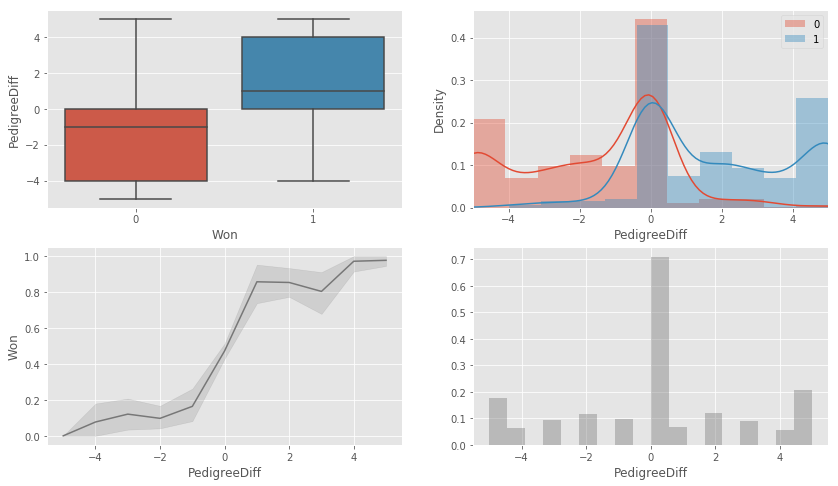

In [21]:
clf_eda_numeric(pedigree_df.query("Season >= 2003"), feature='PedigreeDiff')

### Engineer Feature #4: Tournament Head-to-Head in Prior Seasons

TODO: consider switching to Boolean, or weighting more recent results more heavily 

Currently using `TourneyH2HEdge` as the main feature to describe head-to-head track record between two teams, measured as # of wins minus # of losses from the lower-ID team's perspective. 

In [22]:
def append_tourney_head_to_head(data, tourney_results, ignore_before=None):
    """ Given data w/ tourney results, append head-to-head features """
    
    # if data contains label, remove before joining
    df = data.copy()
    if 'Won' in df.columns: 
        df = df.drop('Won', axis=1)
    
    # filter out older results 
    if ignore_before:
        tourney_results = tourney_results[tourney_results['Season'] >= ignore_before]
    tourney_results_reformatted = reformat_results(tourney_results)

    # generate head-to-head metrics 
    tourney_h2h = df\
        .merge(tourney_results_reformatted, how='left', on='Teams', suffixes=('_1', '_2'))\
        .query("Season_1 > Season_2")\
        .groupby(['Teams', 'Season_1'])\
        .agg({'Won': ['size', np.sum], 'ScoreDiff': [np.sum]})\
        .reset_index()
    tourney_h2h.columns = ['Teams', 'Season', 'TourneyH2HTotal', 'TourneyH2HWins', 'TourneyH2HScoreDiff']
    tourney_h2h['TourneyH2HLosses'] = tourney_h2h['TourneyH2HTotal'] - tourney_h2h['TourneyH2HWins']
    tourney_h2h['TourneyH2HEdge'] = tourney_h2h['TourneyH2HWins'] - tourney_h2h['TourneyH2HLosses']
    
    # append to main dataframe 
    output = data.merge(tourney_h2h, how='left', on=['Season','Teams']).fillna(0)
    for col in ['TourneyH2HTotal', 'TourneyH2HWins', 'TourneyH2HLosses', 'TourneyH2HEdge', 'TourneyH2HScoreDiff']:
        output[col] = output[col].astype(int)
    
    return output

In [23]:
tourney_h2h_df = append_tourney_head_to_head(labeled_pairs, tourney_results)
tourney_h2h_df.query("Teams == '1403_1438'")

,Season,TeamA,TeamB,Teams,ID,Won,TourneyH2HTotal,TourneyH2HWins,TourneyH2HScoreDiff,TourneyH2HLosses,TourneyH2HEdge
2205,2019,1403,1438,1403_1438,2019_1403_1438,0,0,0,0,0,0


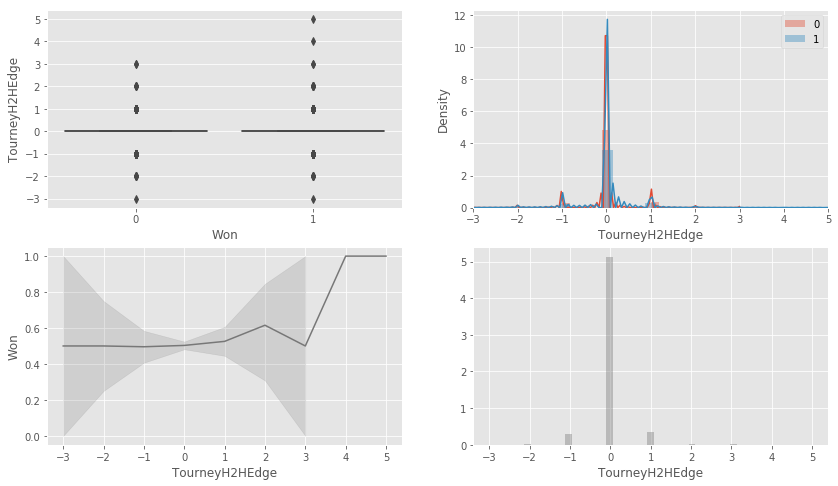

In [24]:
clf_eda_numeric(tourney_h2h_df, feature='TourneyH2HEdge')

### Engineer Feature #5: Regular Season Head-to-Head in Current Season

TODO: consider switching to Boolean

Similar to `TourneyH2HEdge`, except `RegularH2HEdge` considers only regular season games in the current season. 

In [25]:
def append_regular_head_to_head(data, regular_results):
    """ Append regular season head-to-head features to dataframe """
    
    # if data contains label, remove before joining
    df = data.copy()
    if 'Won' in df.columns: 
        df = df.drop('Won', axis=1)
    
    regular_results_reformatted = reformat_results(regular_results)
    
    # generate head-to-head metrics using current regular season only 
    regular_h2h = df\
        .merge(regular_results_reformatted, how='left', on='ID', suffixes=('_1', '_2'))\
        .groupby('ID')\
        .agg({'Won': [lambda x: x.count(), np.sum], 'ScoreDiff': [np.sum]})\
        .reset_index()
    regular_h2h.columns = ['ID', 'RegularH2HTotal', 'RegularH2HWins', 'RegularH2HScoreDiff']
    regular_h2h['RegularH2HLosses'] = regular_h2h['RegularH2HTotal'] - regular_h2h['RegularH2HWins']
    regular_h2h['RegularH2HEdge'] = regular_h2h['RegularH2HWins'] - regular_h2h['RegularH2HLosses']
    
    # append to main dataframe 
    output = data.merge(regular_h2h, how='left', on=['ID']).fillna(0)
    for col in ['RegularH2HTotal', 'RegularH2HWins', 'RegularH2HLosses', 'RegularH2HEdge', 'RegularH2HScoreDiff']:
        output[col] = output[col].astype(int)
    
    return output

In [26]:
regular_h2h_df = append_regular_head_to_head(labeled_pairs, regular_results)
display(regular_h2h_df.query("Teams == '1403_1438'")) # UVA and TexasTech never played each other in regular season
display(regular_h2h_df.query('RegularH2HEdge != 0').tail(3))

,Season,TeamA,TeamB,Teams,ID,Won,RegularH2HTotal,RegularH2HWins,RegularH2HScoreDiff,RegularH2HLosses,RegularH2HEdge
2205,2019,1403,1438,1403_1438,2019_1403_1438,0,0,0,0,0,0


,Season,TeamA,TeamB,Teams,ID,Won,RegularH2HTotal,RegularH2HWins,RegularH2HScoreDiff,RegularH2HLosses,RegularH2HEdge
2185,2019,1181,1439,1181_1439,2019_1181_1439,1,1,0,-5,1,-1
2188,2019,1277,1278,1277_1278,2019_1277_1278,1,1,1,24,0,1
2226,2019,1120,1246,1120_1246,2019_1120_1246,1,2,0,-29,2,-2


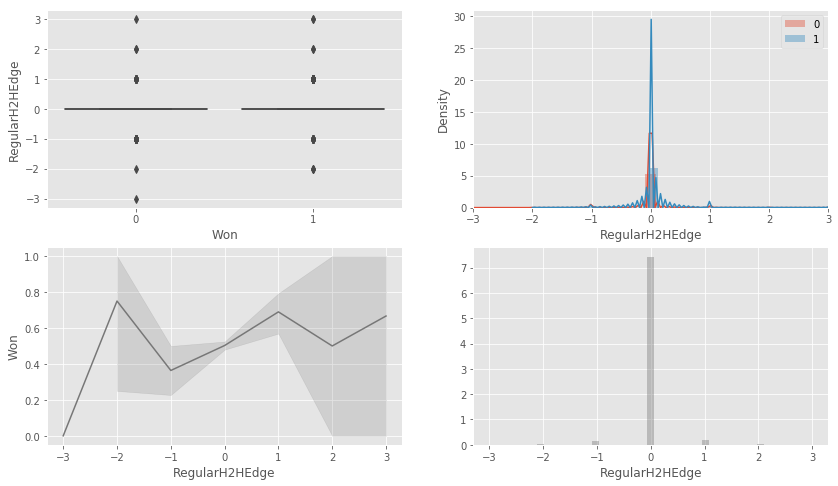

In [27]:
clf_eda_numeric(regular_h2h_df, feature='RegularH2HEdge')

### Put It Altogether

In [28]:
DATA = {'seeds': pd.read_csv('data/MDataFiles_Stage1/MNCAATourneySeeds.csv'), 
        'public_rankings': pd.read_csv('data/MDataFiles_Stage1/MMasseyOrdinals.csv'), 
        'tourney_results': pd.read_csv('data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv'),
        'regular_results': pd.read_csv('data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv'),
        }

In [29]:
def construct_dataset(seasons, train=True, ignore_before=None, input_data=DATA):
    """ Given a range of seasons to train/predict on, chain together data wrangling steps to generate train/test 
        datasets from raw data. 
    
        Parameters
        ----------
        seasons : tuple
            A tuple (season_start, season_end) specifying which seasons we want to include in our train/test sets 
        ignore_before : int, default=None
            Data from seasons prior to ignore_before will not be used to engineer Tourney H2H features
        train : boolean, default=True 
            If train=True, only realized match-ups will be returned, along with their match outcomes as labels. 
            If train=False, all possible match-ups will be returned, with no labels. 
            
        Returns
        -------
        dataset : pd.DataFrame
            Either a train or test dataset with a complete set of engineered features 
    """
    
    # parse input 
    seeds, tourney_results = input_data['seeds'], input_data['tourney_results']
    season_start, season_end = seasons 
    
    # generate matchups 
    df = create_match_ups(seeds, seasons=seasons)
    
    # engineer and append features 
    tourney_results_reformatted = reformat_results(tourney_results)
    df = append_seed_features(df, seeds)
    df = append_ranking_features(df, public_rankings)
    df = append_pedigree_features(df, tourney_results)
    df = append_tourney_head_to_head(df, tourney_results, ignore_before)
    df = append_regular_head_to_head(df, regular_results)

    if train is True: 
        df = append_labels(df, tourney_results)
    
    return df

# Fit Model

### Helper Functions 

In [30]:
# here we define a train/test split function to use all data preceding each season to train a model 

def train_test_period_split(data, season_to_predict, season_to_start): 
    """ Split data into train vs. test datasets. 
        - Test set comprises only the single season specified; 
        - Train set comprises all data between season_to_start through the season before the one to predict on 
    """
    
    train_data = data.query("Season >= @season_to_start & Season < @season_to_predict")
    test_data = data.query("Season == @season_to_predict")

    return train_data, test_data

In [31]:
def iterative_train(model, seasons_to_predict, data, features, season_to_start): 
    """ For each season to predict, instantiate the model and fit to a different train set using all prior seasons 
        (beginning from season_to_start). Returns a dictionary with {season:model} value pairs. 
    """
    models = {} 
    for season in seasons_to_predict:
        train_data, _ = train_test_period_split(data, season, season_to_start)
        X_train, y_train = train_data[features], train_data['Won']
        models[season] = clone(model)
        models[season].fit(X_train, y_train)
    
    return models 

def iterative_predict(models, seasons_to_predict, data, features, season_to_start):
    """ Iterate over list of models and predict on each relevant season. 
        Returns a subset of data (of relevant seasons) with prediction appended as a new column. 
    """
    pred_dfs = []
    
    for season in seasons_to_predict: 
        _, test_data = train_test_period_split(data, season, season_to_start)
        df = test_data.copy() 
        df['Pred'] = models[season].predict_proba(df[features])[:,1]
        pred_dfs.append(df)
        
    return pd.concat(pred_dfs)

In [32]:
def evaluate_predictions(y_true, y_score, cls_threshold=.5, plot=False):
    """ Given labels and predictions, return a dictionary with classifier evaluation metrics. 
        Optionally, plot ROC and Precision-Recall curves. 
    """
    
    y_pred = y_score > cls_threshold
    metrics = {} 
    metrics['LogLoss'] = log_loss(y_true, y_score)
    metrics['AuROC'] = roc_auc_score(y_true, y_score)
    metrics['AuPR'] = average_precision_score(y_true, y_score)
    metrics['BalancedAcc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1'] = f1_score(y_true, y_pred)
    
    if plot: 
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
        color1 = list(plt.rcParams['axes.prop_cycle'])[0]['color']
        color2 = list(plt.rcParams['axes.prop_cycle'])[1]['color']
        
        # TODO: refactor curve plotting code 
        # plot roc curve 
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        axes[0].plot(fpr, tpr, color=color1, lw=2, 
                     label='ROC curve (AuROC = %0.3f)' % metrics['AuROC'])
        axes[0].plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='No Skill')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve')
        axes[0].legend(loc="lower right")
        
        # plot precision-recall curve 
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_score)
        axes[1].plot(recalls, precisions, color=color2, lw=2, 
                     label='Precision-Recall Curve (AuPR = %0.3f)' % metrics['AuPR'])
        no_skill = sum(y_true) / len(y_true)
        axes[1].plot([0, 1], [no_skill, no_skill], color='grey', lw=2, linestyle='--', label='No Skill')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Precision-Recall Curve')
        axes[1].legend(loc="lower right")        
        
    return metrics 

In [33]:
train_data = construct_dataset(seasons=(2003, 2019))
seasons_to_predict = [2015,2016,2017,2018,2019]
season_to_start = 2003

### Baseline Model: Logistic Regression w/ SeedDiff

{'LogLoss': 0.5581267480069967,
 'AuROC': 0.7824463118580767,
 'AuPR': 0.7508668454432678,
 'BalancedAcc': 0.7028837175895999,
 'Precision': 0.6586826347305389,
 'Recall': 0.7189542483660131,
 'F1': 0.6875}

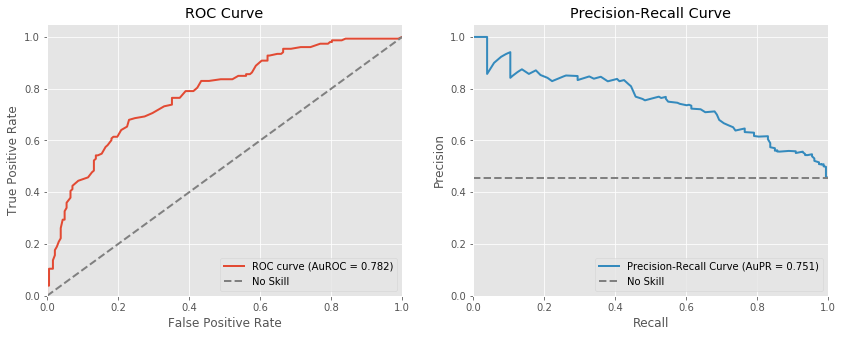

In [34]:
lr1_features = ['SeedDiff']
lr1 = LogisticRegression()
lr1_models = iterative_train(lr1, seasons_to_predict, train_data, lr1_features, season_to_start)
lr1_preds = iterative_predict(lr1_models, seasons_to_predict, train_data, lr1_features, season_to_start)
evaluate_predictions(lr1_preds['Won'], lr1_preds['Pred'], cls_threshold=.5, plot=True)

### Current Model: Logistic Regression w/ Seed + Ranking + Pedigree + Tourney H2H + Regular H2H

{'LogLoss': 0.4273143299103145,
 'AuROC': 0.8847231200172377,
 'AuPR': 0.8672179540757327,
 'BalancedAcc': 0.7922143216260864,
 'Precision': 0.7763157894736842,
 'Recall': 0.7712418300653595,
 'F1': 0.7737704918032787}

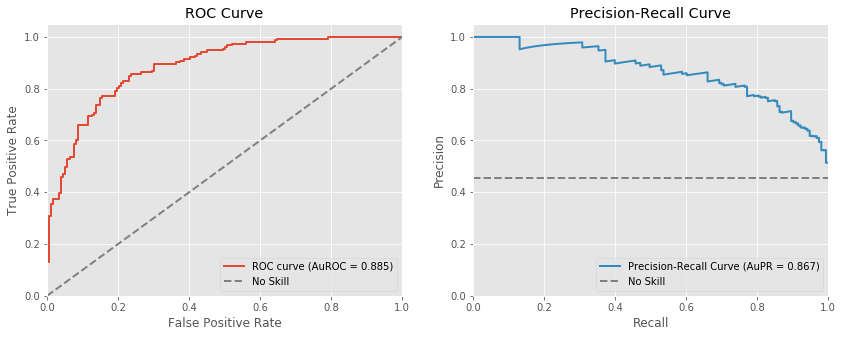

In [35]:
# check no target leakage in PedigreeDiff
lr2_features = ['SeedDiff','RankDiffMAX', 'PedigreeDiff', 'TourneyH2HEdge', 'RegularH2HEdge']
lr2 = LogisticRegression()
lr2_models = iterative_train(lr2, seasons_to_predict, train_data, lr2_features, season_to_start)
lr2_preds = iterative_predict(lr2_models, seasons_to_predict, train_data, lr2_features, season_to_start)
evaluate_predictions(lr2_preds['Won'], lr2_preds['Pred'], cls_threshold=.5, plot=True)

### Logistic Regression w/ StatsModels 

In [36]:
import statsmodels.discrete.discrete_model as sm
train, _ = train_test_period_split(data=train_data, season_to_predict=2016, season_to_start=season_to_start)
X_train, y_train = train[lr2_features], train['Won']
logit = sm.Logit(y_train, X_train)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.414329
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Won   No. Observations:                  847
Model:                          Logit   Df Residuals:                      842
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.4021
Time:                        00:50:14   Log-Likelihood:                -350.94
converged:                       True   LL-Null:                       -587.00
Covariance Type:            nonrobust   LLR p-value:                7.173e-101
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
SeedDiff           0.0541      0.025      2.167      0.030       0.005       0.103
RankDiffMAX        0.0042      0.003      1.403      0.160      -0.002       0.010
PedigreeDiff       0.7540      0.071     10.582      0.000       0.614       0.894
TourneyH2HEdge    -0.1095      0.167     -0.656      0.512      -0.437       0.218
RegularH2HEdge     0.5919      0.411      1.440      0.150      -0.213       1.397
==================================================================================
"""

# Output Predictions

Here we output the predictions in the format required by Kaggle. For every possible pair-wise matchup between teams that qualified for March Madness each season, we need to predict the probability that the lower-ID team wins. Our prediction output comprises a CSV with two columns: ID, Pred 

In [37]:
# check submission format for Round 1 
sample_pred = pd.read_csv('data/MSampleSubmissionStage1_2020.csv')
display(sample_pred.head())
print(len(sample_pred))

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


11390


In [38]:
new_data = construct_dataset(seasons=[2015,2019], train=False, ignore_before=None, input_data=DATA)
new_preds = iterative_predict(lr2_models, seasons_to_predict, new_data, lr2_features, season_to_start)
new_preds.sort_values('ID', inplace=True)
new_preds = new_preds[['ID', 'Pred']]
display(new_preds.head())
new_preds.to_csv('my_predictions_stage1.csv', index=False)

,ID,Pred
468,2015_1107_1112,0.006723
471,2015_1107_1116,0.259424
469,2015_1107_1124,0.251023
431,2015_1107_1125,0.513047
427,2015_1107_1129,0.342682
